In [1]:
path_main_summarized_table = "../results/2023-05-24/00_processed/main/aurocs.tsv.gz"
path_crossprot_summarized_table = "../results/2023-05-24/00_processed/crossProt/aurocs.tsv.gz"

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./cross_protocols/"
export = True


# Forewords

Cross protocols type application of models

# Imports


In [3]:
import copy
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/l10n/projects/hzm/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Set-up

In [4]:
if export:
    if not Path(path_output_dir).exists():
        Path(path_output_dir).mkdir(parents=True, exist_ok=True)

# Load

## Config

In [5]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


## Data

In [6]:
full_summary_table = pd.read_csv(
    path_main_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

In [7]:
full_summary_table_prot = pd.read_csv(
    path_crossprot_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

full_summary_table_prot["RBP-name"] = (
    full_summary_table_prot["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 0]
    .values
)
full_summary_table_prot["CT"] = (
    full_summary_table_prot["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 1]
    .values
)

# Format

In [8]:
ENCODE_RBP_LIST =  [
    'EIF3D_HepG2',
    'EIF3G_K562',
    'EWSR1_K562',
    'FUS_HepG2',
    'FXR1_K562',
    'FXR2_HepG2',
    'IGF2BP1_HepG2',
    'IGF2BP2_K562',
    'IGF2BP3_HepG2',
    'LIN28B_HepG2',
    'PUM2_K562',
    'QKI_HepG2',
    'SSB_HepG2',
    'TAF15_HepG2',
    'TARDBP_K562',
    'UPF1_HepG2',
    'XPO5_HepG2',
]

PARCLIP_RBP_LIST = [
    'EIF3D_HEK293_PARCLIP',
    'EIF3G_HEK293_PARCLIP',
    'EWSR1_HEK293_PARCLIP',
    'FUS_HEK293_PARCLIP',
    'FXR1_HEK293_PARCLIP',
    'FXR2_HEK293_PARCLIP',
    'IGF2BP1_HEK293_PARCLIP',
    'IGF2BP2_HEK293_PARCLIP',
    'IGF2BP3_HEK293_PARCLIP',
    'LIN28B_HEK293_PARCLIP',
    'PUM2_HEK293_PARCLIP',
    'QKI_HEK293_PARCLIP',
    'SSB_HEK293_PARCLIP',
    'TAF15_HEK293_PARCLIP',
    'TARDBP_HEK293_PARCLIP',
    'UPF1_HEK293_PARCLIP',
    'XPO5_HEK293_PARCLIP',
]

In [9]:
print(full_summary_table['dataset'].unique())
print(full_summary_table_prot['dataset'].unique())

print(full_summary_table.groupby('arch').apply(lambda g: g['RBP_dataset'].unique().shape[0]))
print(full_summary_table_prot.groupby('arch').apply(lambda g: g['RBP_dataset'].unique().shape[0]))

['ENCODE' 'Mukherjee-PAR-CLIP' 'iONMF']
['ENCODE' 'Mukherjee-PAR-CLIP']
arch
BERT-RBP           302
DeepCLIP           302
DeepRAM            302
DeepRiPe           302
DeepRiPe-1         303
GraphProt          302
Multi-resBind      302
Multi-resBind-1    303
MultiRBP           302
PRISMNet           302
Pysster            302
Pysster-101        302
RNAProt            302
RNAProt-seqonly    313
iDeepS             302
dtype: int64
arch
DeepCLIP    34
PRISMNet    34
Pysster     34
iDeepS      34
dtype: int64


In [10]:
#NOTE: most of the code has the same logic as the cross-celltype evaluations.
# Hence I copied the code from the associated notebook, and modified
# column names and logic so as to get the cross-protocol comparison.
# But variable names are still the same as in the cross-celltype notebook...
#TODO: update variable names.


full_summarized_table_ct = full_summary_table_prot

## Cross-evaluations

In [11]:
full_summarized_table_ct['RBP-name'] = full_summarized_table_ct['RBP_dataset'].str.split('_', expand=True).iloc[:,0].values
full_summarized_table_ct['CT'] = full_summarized_table_ct['RBP_dataset'].str.split('_', expand=True).iloc[:,1].values

display(full_summarized_table_ct.head(3))


,unique_id,auroc,arch,dataset,RBP_dataset,fold,model_negativeset,sample_negset,dataset.1,RBP_dataset.1,...,pc_max.pos,pc_avg.neg,pc_avg.pos,cm.tn,cm.fp,cm.fn,cm.tp,cm.thresh,RBP-name,CT
0,0,0.848927,DeepCLIP,ENCODE,EIF3D_HepG2,0,negative-1,negative-1,ENCODE,EIF3D_HepG2,...,0.999275,0.209023,0.613928,0.407115,0.092885,0.144269,0.355731,0.411476,EIF3D,HepG2
1,1,0.834617,DeepCLIP,ENCODE,EIF3D_HepG2,0,negative-2,negative-2,ENCODE,EIF3D_HepG2,...,0.765396,0.413698,0.555141,0.377470,0.122530,0.114625,0.385375,0.484420,EIF3D,HepG2
2,2,0.881710,DeepCLIP,ENCODE,EIF3G_K562,0,negative-1,negative-1,ENCODE,EIF3G_K562,...,0.999213,0.206864,0.669175,0.440120,0.059880,0.137725,0.362275,0.438020,EIF3G,K562


In [12]:
t1_ct_n1 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t1_ct_n2 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_ct_n1 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_ct_n2 = full_summarized_table_ct.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

In [13]:
cross_ct_merged_n1 = pd.merge(
                        t1_ct_n1.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_ct_n1.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


cross_ct_merged_n2 = pd.merge(
                        t1_ct_n2.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_ct_n2.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


## Self evaluations

In [14]:
cross_ct_merged_n1.head(3)

,arch,RBP-name,RBP_dataset.EC,auroc.EC,RBP_dataset.PC,auroc.PC
0,DeepCLIP,EIF3D,EIF3D_HepG2,0.848927,EIF3D_HEK293_PARCLIP,0.741582
1,DeepCLIP,EIF3G,EIF3G_K562,0.881710,EIF3G_HEK293_PARCLIP,0.870375
2,DeepCLIP,EWSR1,EWSR1_K562,0.332009,EWSR1_HEK293_PARCLIP,0.618693


In [15]:
tmp = full_summary_table.loc[
        lambda df: (df['arch'].isin(full_summarized_table_ct['arch'].unique())) & \
                        (df['RBP_dataset'].isin(cross_ct_merged_n1['RBP_dataset.EC'].values) | \
                        df['RBP_dataset'].isin(cross_ct_merged_n1['RBP_dataset.PC'])),
        :].copy()

In [16]:
tmp['RBP-name'] = tmp['RBP_dataset'].str.split('_',expand=True).iloc[:,0].values
tmp['CT'] = tmp['RBP_dataset'].str.split('_',expand=True).iloc[:,1].values   

In [17]:
t1_o_n1 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t1_o_n2 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(ENCODE_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_o_n1 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-1'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

t2_o_n2 = tmp.loc[
                    lambda df: (df['RBP_dataset'].isin(PARCLIP_RBP_LIST)) & (df['model_negativeset']=='negative-2'),:
                ].set_index(['arch','RBP_dataset']).loc[:,['RBP-name','auroc']].reset_index()

In [18]:
cross_o_merged_n1 = pd.merge(
                        t1_o_n1.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_o_n1.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


cross_o_merged_n2 = pd.merge(
                        t1_o_n2.set_index(['arch','RBP-name']).add_suffix('.EC'),
                        t2_o_n2.set_index(['arch','RBP-name']).add_suffix('.PC'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


## Self vs cross

In [19]:
encode_selfcross_merged_n1 = pd.merge(
                        t1_ct_n1.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t1_o_n1.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


encode_selfcross_merged_n2 = pd.merge(
                        t1_ct_n2.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t1_o_n2.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


parclip_selfcross_merged_n1 = pd.merge(
                        t2_ct_n1.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t2_o_n1.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


parclip_selfcross_merged_n2 = pd.merge(
                        t2_ct_n2.set_index(['arch','RBP-name']).add_suffix('.cross'),
                        t2_o_n2.set_index(['arch','RBP-name']).add_suffix('.self'),
                        left_index=True,
                        right_index=True,
                        how='inner'
                    ).reset_index()


## Relative drop in performance

In [23]:
def calculate_relative_drop_auroc(selfcross_df: pd.DataFrame) -> pd.Series:
    return (selfcross_df["auroc.cross"] - selfcross_df["auroc.self"]) / selfcross_df[
        "auroc.self"
    ]


parclip_selfcross_merged_n1["auroc.reldrop"] = calculate_relative_drop_auroc(
    parclip_selfcross_merged_n1
)
parclip_selfcross_merged_n2["auroc.reldrop"] = calculate_relative_drop_auroc(
    parclip_selfcross_merged_n2
)
encode_selfcross_merged_n1["auroc.reldrop"] = calculate_relative_drop_auroc(
    encode_selfcross_merged_n1
)
encode_selfcross_merged_n2["auroc.reldrop"] = calculate_relative_drop_auroc(
    encode_selfcross_merged_n2
)


# Relative drop in performance

For a given model, compute the % drop in auROC, separated by negative set.

Questions to answer:

- are some methods more sensitive than others?
- are some RBPs more sensitive than others?

## Data

In [24]:
reldrop_data = pd.concat(
    [
        parclip_selfcross_merged_n1.assign(
            modelsource="PARCLIP-neg1",
            negativeset="neg1",
        ),
        encode_selfcross_merged_n1.assign(
            modelsource="ENCODE-neg1",
            negativeset="neg1",
        ),
        parclip_selfcross_merged_n2.assign(
            modelsource="PARCLIP-neg2",
            negativeset="neg2",
        ),
        encode_selfcross_merged_n2.assign(
            modelsource="ENCODE-neg2",
            negativeset="neg2",
        ),
    ],
    axis=0,
)


In [25]:
tmp_reldrop_avg = reldrop_data.groupby('modelsource')['auroc.reldrop'].mean().rename('average_auroc_relative_drop').to_frame().reset_index()

display(tmp_reldrop_avg)

,modelsource,average_auroc_relative_drop
0,ENCODE-neg1,-0.242120
1,ENCODE-neg2,-0.191132
2,PARCLIP-neg1,-0.252572
3,PARCLIP-neg2,-0.260170


## Boxplot

Saving


<Figure size 775.974x775.974 with 0 Axes>

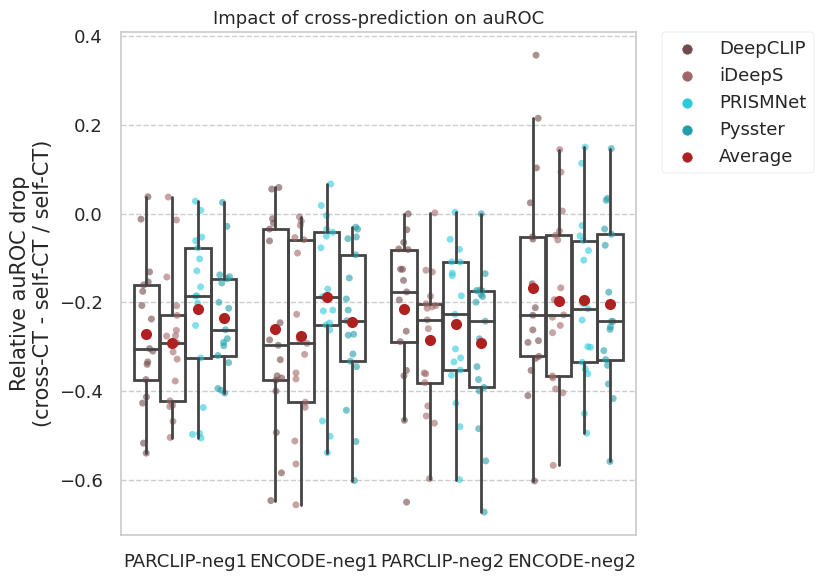

In [29]:

panel_name = "j"

figure_name = "self_vs_cross_prot_aurocs.relative_drops_boxplots"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
fig = plt.figure(figsize=(8.5, 6))
ax1 = fig.add_subplot(1, 1, 1)

BOXPLOT_PROPS = {
    "boxprops": {"facecolor": "none", "edgecolor": "#444444"},
    "medianprops": {"color": "#444444"},
    "whiskerprops": {"color": "#444444"},
    "capprops": {"color": "none"},
    "meanprops": {
        "marker": "o",
        "markerfacecolor": "#AF2121",
        "markeredgecolor": "#AF2121",
        "markersize": 8,
    },
}

sns.boxplot(
    data=reldrop_data,
    x="modelsource",
    y="auroc.reldrop",
    hue="arch",
    # inner=None,
    palette=arch_colors,
    linewidth=2,
    ax=ax1,
    showmeans=True,
    showfliers=False,
    zorder=50,
    **BOXPLOT_PROPS
)

# Remove facecolor of boxplot/violins, by using the alpha parameter
for path in ax1.collections:
    path.set_facecolor(
        "#FFFFFF00",
    )

sns.stripplot(
    data=reldrop_data,
    x="modelsource",
    y="auroc.reldrop",
    hue="arch",
    dodge=True,
    jitter=0.2,
    palette=arch_colors,
    alpha=0.6,
    zorder=1,
    ax=ax1,
)

ax1.set_ylabel("Relative auROC drop\n(cross-CT - self-CT / self-CT)")
ax1.set_xlabel("")

title = "Impact of cross-prediction on auROC"
ax1.set_title(title)


h, l = ax1.get_legend_handles_labels()
h, l = h[len(h) // 2 :], l[len(l) // 2 :],
# Add average.
avg = copy.copy(h[-1])
avg.set_color("#AF2121")
h.append(avg)
l.append("Average")
ax1.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)

plt.tight_layout()


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)


plt.show()


# Plot

## Scatter - self protocol

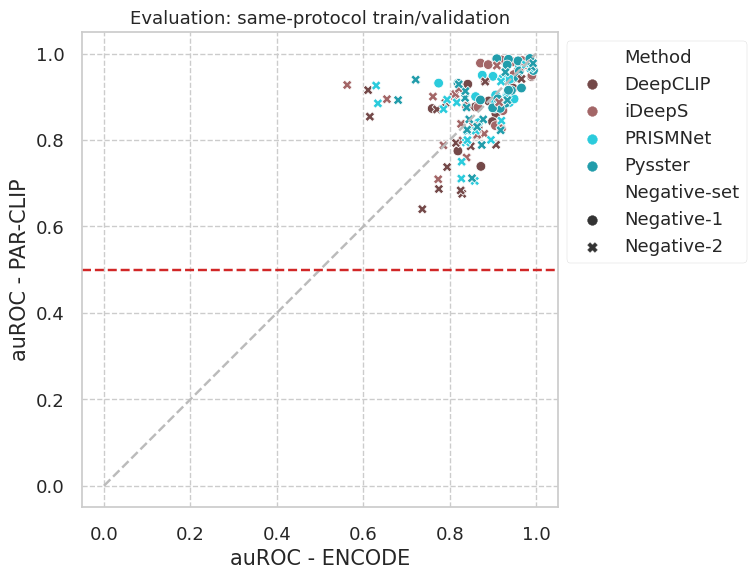

In [30]:
panel_name = 'kl'

figure_name = "self_protocol_aurocs.PAR-CLIP_vs_ENCODE"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            cross_o_merged_n1.assign(negativeset='Negative-1'),
            cross_o_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.EC',
    y='auroc.PC',
    hue='Method',
    style='Negative-set',
    palette=arch_colors,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

#ax1.set_xlim([0.55,1.05])
#ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - ENCODE')
ax1.set_ylabel('auROC - PAR-CLIP')

ax1.set_title("Evaluation: same-protocol train/validation")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()

if savefig_file:
    my_savefig(savefig_file)
    

plt.show()

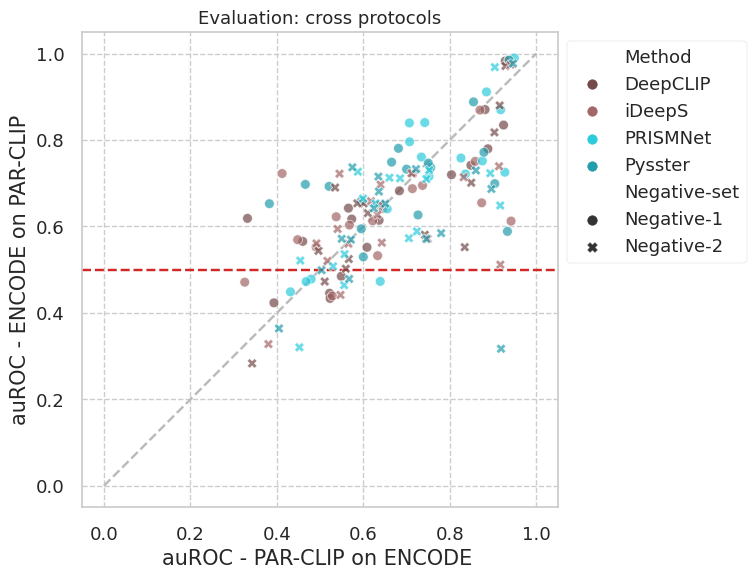

In [35]:
panel_name = 'i'

figure_name = "cross_protocol_aurocs.PAR-CLIP_vs_ENCODE"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES[panel_name]])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            cross_ct_merged_n1.assign(negativeset='Negative-1'),
            cross_ct_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.EC',
    y='auroc.PC',
    hue='Method',
    style='Negative-set',
    palette=arch_colors,
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])

ax1.set_xlabel('auROC - PAR-CLIP on ENCODE ')
ax1.set_ylabel('auROC - ENCODE on PAR-CLIP')

ax1.set_title("Evaluation: cross protocols")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    my_savefig(savefig_file)

plt.show()

## Scatter 2 : self vs cross

Saving


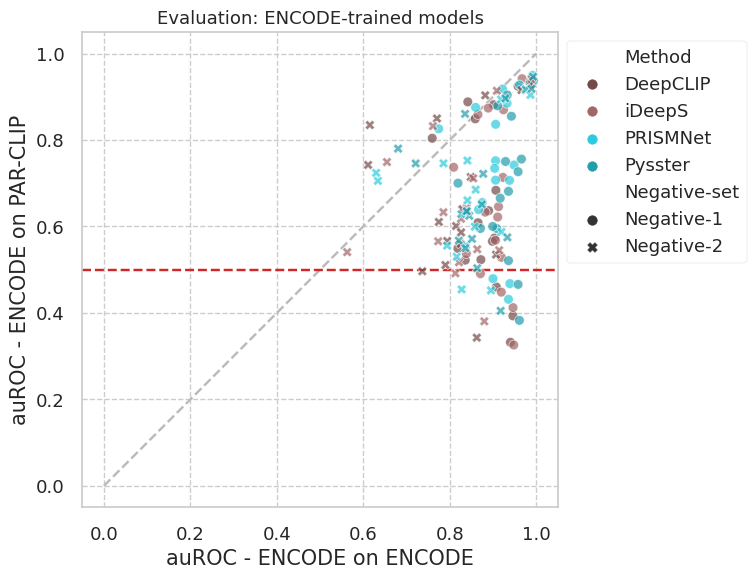

In [36]:
panel_name = 'k'

figure_name = "self_vs_cross_protocols_aurocs.ENCODE"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            encode_selfcross_merged_n1.assign(negativeset='Negative-1'),
            encode_selfcross_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.self',
    y='auroc.cross',
    hue='Method',
    palette=arch_colors,
    style='Negative-set',
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - ENCODE on ENCODE')
ax1.set_ylabel('auROC - ENCODE on PAR-CLIP')


ax1.set_title("Evaluation: ENCODE-trained models")


fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)
    

plt.show()

Saving


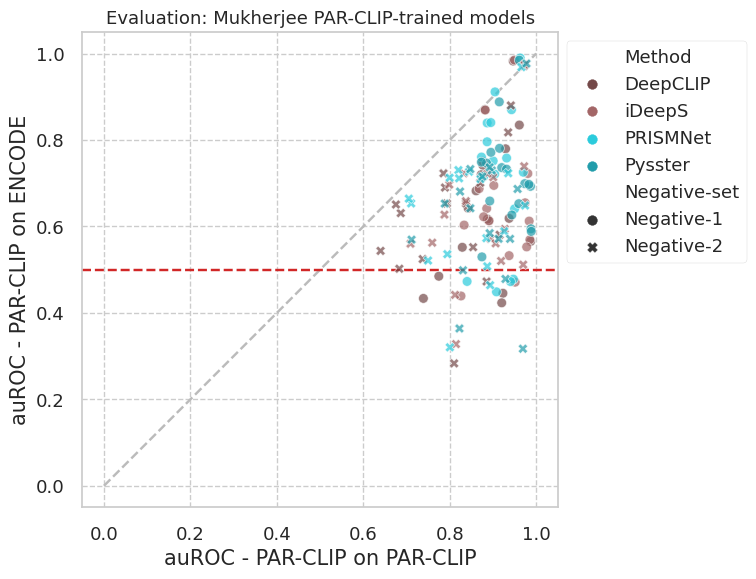

In [37]:
panel_name = 'l'

figure_name = "self_vs_cross_protocols_aurocs.PAR-CLIP"

if export:
    savefig_file = str(Path(path_output_dir) / f"{figure_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v*5 for v in FIG3_PANEL_SIZES['i']])
ax1 = fig.add_subplot(1,1,1,)

sns.scatterplot(
    data=pd.concat([
            parclip_selfcross_merged_n1.assign(negativeset='Negative-1'),
            parclip_selfcross_merged_n2.assign(negativeset='Negative-2'),]
            ).rename(columns={'arch':'Method','negativeset':'Negative-set'}),
    x='auroc.self',
    y='auroc.cross',
    hue='Method',
    palette=arch_colors,
    style='Negative-set',
    zorder=10,
    alpha=0.7,
    ax=ax1)

plt.legend(bbox_to_anchor=(1,1,))


ax1.plot([0,1],[0,1], linestyle='--', color='#BBBBBB')
ax1.axhline(0.5, linestyle='--', color='#D12727')

ax1.set_aspect('equal')

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel('auROC - PAR-CLIP on PAR-CLIP')
ax1.set_ylabel('auROC - PAR-CLIP on ENCODE')

ax1.set_title("Evaluation: Mukherjee PAR-CLIP-trained models")


#ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)

plt.tight_layout()

if savefig_file:
    print("Saving")
    my_savefig(savefig_file)
    

plt.show()